In [2]:
# import cartopy 
# print(cartopy.config['data_dir'])

In [3]:
import cartopy 
cartopy.config['data_dir'] = '/home/hzafar/.local/share/cartopy'
cartopy.config['pre_existing_data_dir'] = '/home/hzafar/.local/share/cartopy'

ERROR 1: PROJ: proj_create_from_database: Open of /usr/local/other/GEOSpyD/24.4.0-0_py3.12/2024-05-31/share/proj failed


In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import xarray as xr
import pandas as pd
import cartopy
from cartopy import crs as ccrs, feature as cfeature
import glob
import os
import time

## Functions

In [5]:
def get_single_match(pattern):
    matches = glob.glob(pattern)
    if len(matches) == 1:
        return matches[0]
    elif len(matches) == 0:
        raise ValueError(f"No matches found")
    else:
        raise ValueError(f"Multiple matches found: {matches}")

In [6]:
def normalize_rgb(colors):
    """Normalize a list of RGB colors from 0-255 to 0-1 range."""
    return [(r/255, g/255, b/255) for r, g, b in colors]

In [7]:
def create_color_dict(colors, positions, alpha=None):
    """
    Creates a dictionary for red, green, and blue channels, optionally adding alpha.

    Parameters:
        colors (list of tuples): List of RGB values in 0-255 range.
        positions (list): List of positions corresponding to the colors.
        alpha (list of tuples, optional): List of alpha channel values.

    Returns:
        dict: A dictionary with red, green, blue, and optionally alpha mappings.
    """
    normalized_colors = normalize_rgb(colors)
    cdict = {'red': [], 'green': [], 'blue': []}

    # Create red, green, and blue mappings
    for pos, (r, g, b) in zip(positions, normalized_colors):
        cdict['red'].append((pos, r, r))
        cdict['green'].append((pos, g, g))
        cdict['blue'].append((pos, b, b))

    # Add alpha channel if provided (only if alpha is not None)
    if alpha is not None:
        cdict['alpha'] = alpha

    return cdict

## Import NEE data

In [8]:
filepath = 'micasa-data/daily-0.1deg-final/holding/3hrly/2024/09/MiCASA_v1_flux_x3600_y1800_3hrly_202409*.nc4'
ds = xr.open_mfdataset(filepath, combine="by_coords", chunks={})['NEE']
ds

<xarray.DataArray 'NEE' (time: 240, lat: 1800, lon: 3600)> Size: 6GB
dask.array<concatenate, shape=(240, 1800, 3600), dtype=float32, chunksize=(1, 600, 1200), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 14kB -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
  * lon      (lon) float64 29kB -179.9 -179.8 -179.8 ... 179.8 179.8 179.9
  * time     (time) datetime64[ns] 2kB 2024-09-01 ... 2024-09-30T21:00:00
Attributes:
    units:         kg m-2 s-1
    expressed_as:  carbon
    long_name:     Net ecosystem exchange

## Preprocess data for plotting

In [9]:
# Plot only North America, drop unused lat/lon
# min_lon, max_lon = -170, -30
# min_lat, max_lat = 10, 70
min_lon, max_lon = -140, -55
min_lat, max_lat = 15, 60
proj=ccrs.PlateCarree()

In [10]:
# Plot only two days for testing
time_start, time_stop = '2024-09-26', '2024-09-27'

In [11]:
ds_subset = ds.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon,max_lon), time=slice(time_start,time_stop))
ds_subset

<xarray.DataArray 'NEE' (time: 16, lat: 450, lon: 850)> Size: 24MB
dask.array<getitem, shape=(16, 450, 850), dtype=float32, chunksize=(1, 300, 800), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 4kB 15.05 15.15 15.25 15.35 ... 59.75 59.85 59.95
  * lon      (lon) float64 7kB -139.9 -139.8 -139.8 ... -55.25 -55.15 -55.05
  * time     (time) datetime64[ns] 128B 2024-09-26 ... 2024-09-27T21:00:00
Attributes:
    units:         kg m-2 s-1
    expressed_as:  carbon
    long_name:     Net ecosystem exchange

In [12]:
# mask zeroes
ds_subset_mask = ds_subset.where(ds_subset != 0)
ds_subset_mask

<xarray.DataArray 'NEE' (time: 16, lat: 450, lon: 850)> Size: 24MB
dask.array<where, shape=(16, 450, 850), dtype=float32, chunksize=(1, 300, 800), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 4kB 15.05 15.15 15.25 15.35 ... 59.75 59.85 59.95
  * lon      (lon) float64 7kB -139.9 -139.8 -139.8 ... -55.25 -55.15 -55.05
  * time     (time) datetime64[ns] 128B 2024-09-26 ... 2024-09-27T21:00:00
Attributes:
    units:         kg m-2 s-1
    expressed_as:  carbon
    long_name:     Net ecosystem exchange

## Plot each time stamp as a static output

In [13]:
# Define output directory
output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)
filename = 'micasa'

In [14]:
# Define the colormap colors/transparency
colors = [
    (109, 10, 245),
    (255, 255, 255),
    (245, 138, 0)
]
# Define the position of these colors
positions = [0, 0.5, 1]

# Define alpha
alpha = [(0.0, 1.0, 1.0), # Opaque at 0 
          (0.4, 0.8, 0.8), 
          (0.5, 0, 0), 
          (0.6,  0.8, 0.8), 
          (1.0, 1.0, 1.0)]  # Opaque at 1

In [15]:
# Make a custom colormap
cdict = create_color_dict(colors,positions,alpha)
custom_cmap = mcolors.LinearSegmentedColormap('custom_cmap', cdict)

In [16]:
# Test the colormap
# gradient = np.linspace(-1, 1, 256).reshape(1, -1)
# fig, ax = plt.subplots(figsize=(8, 1))
# ax.imshow(gradient, aspect="auto", cmap=custom_cmap)
# ax.set_xticks([])
# ax.set_yticks([])
# plt.show()

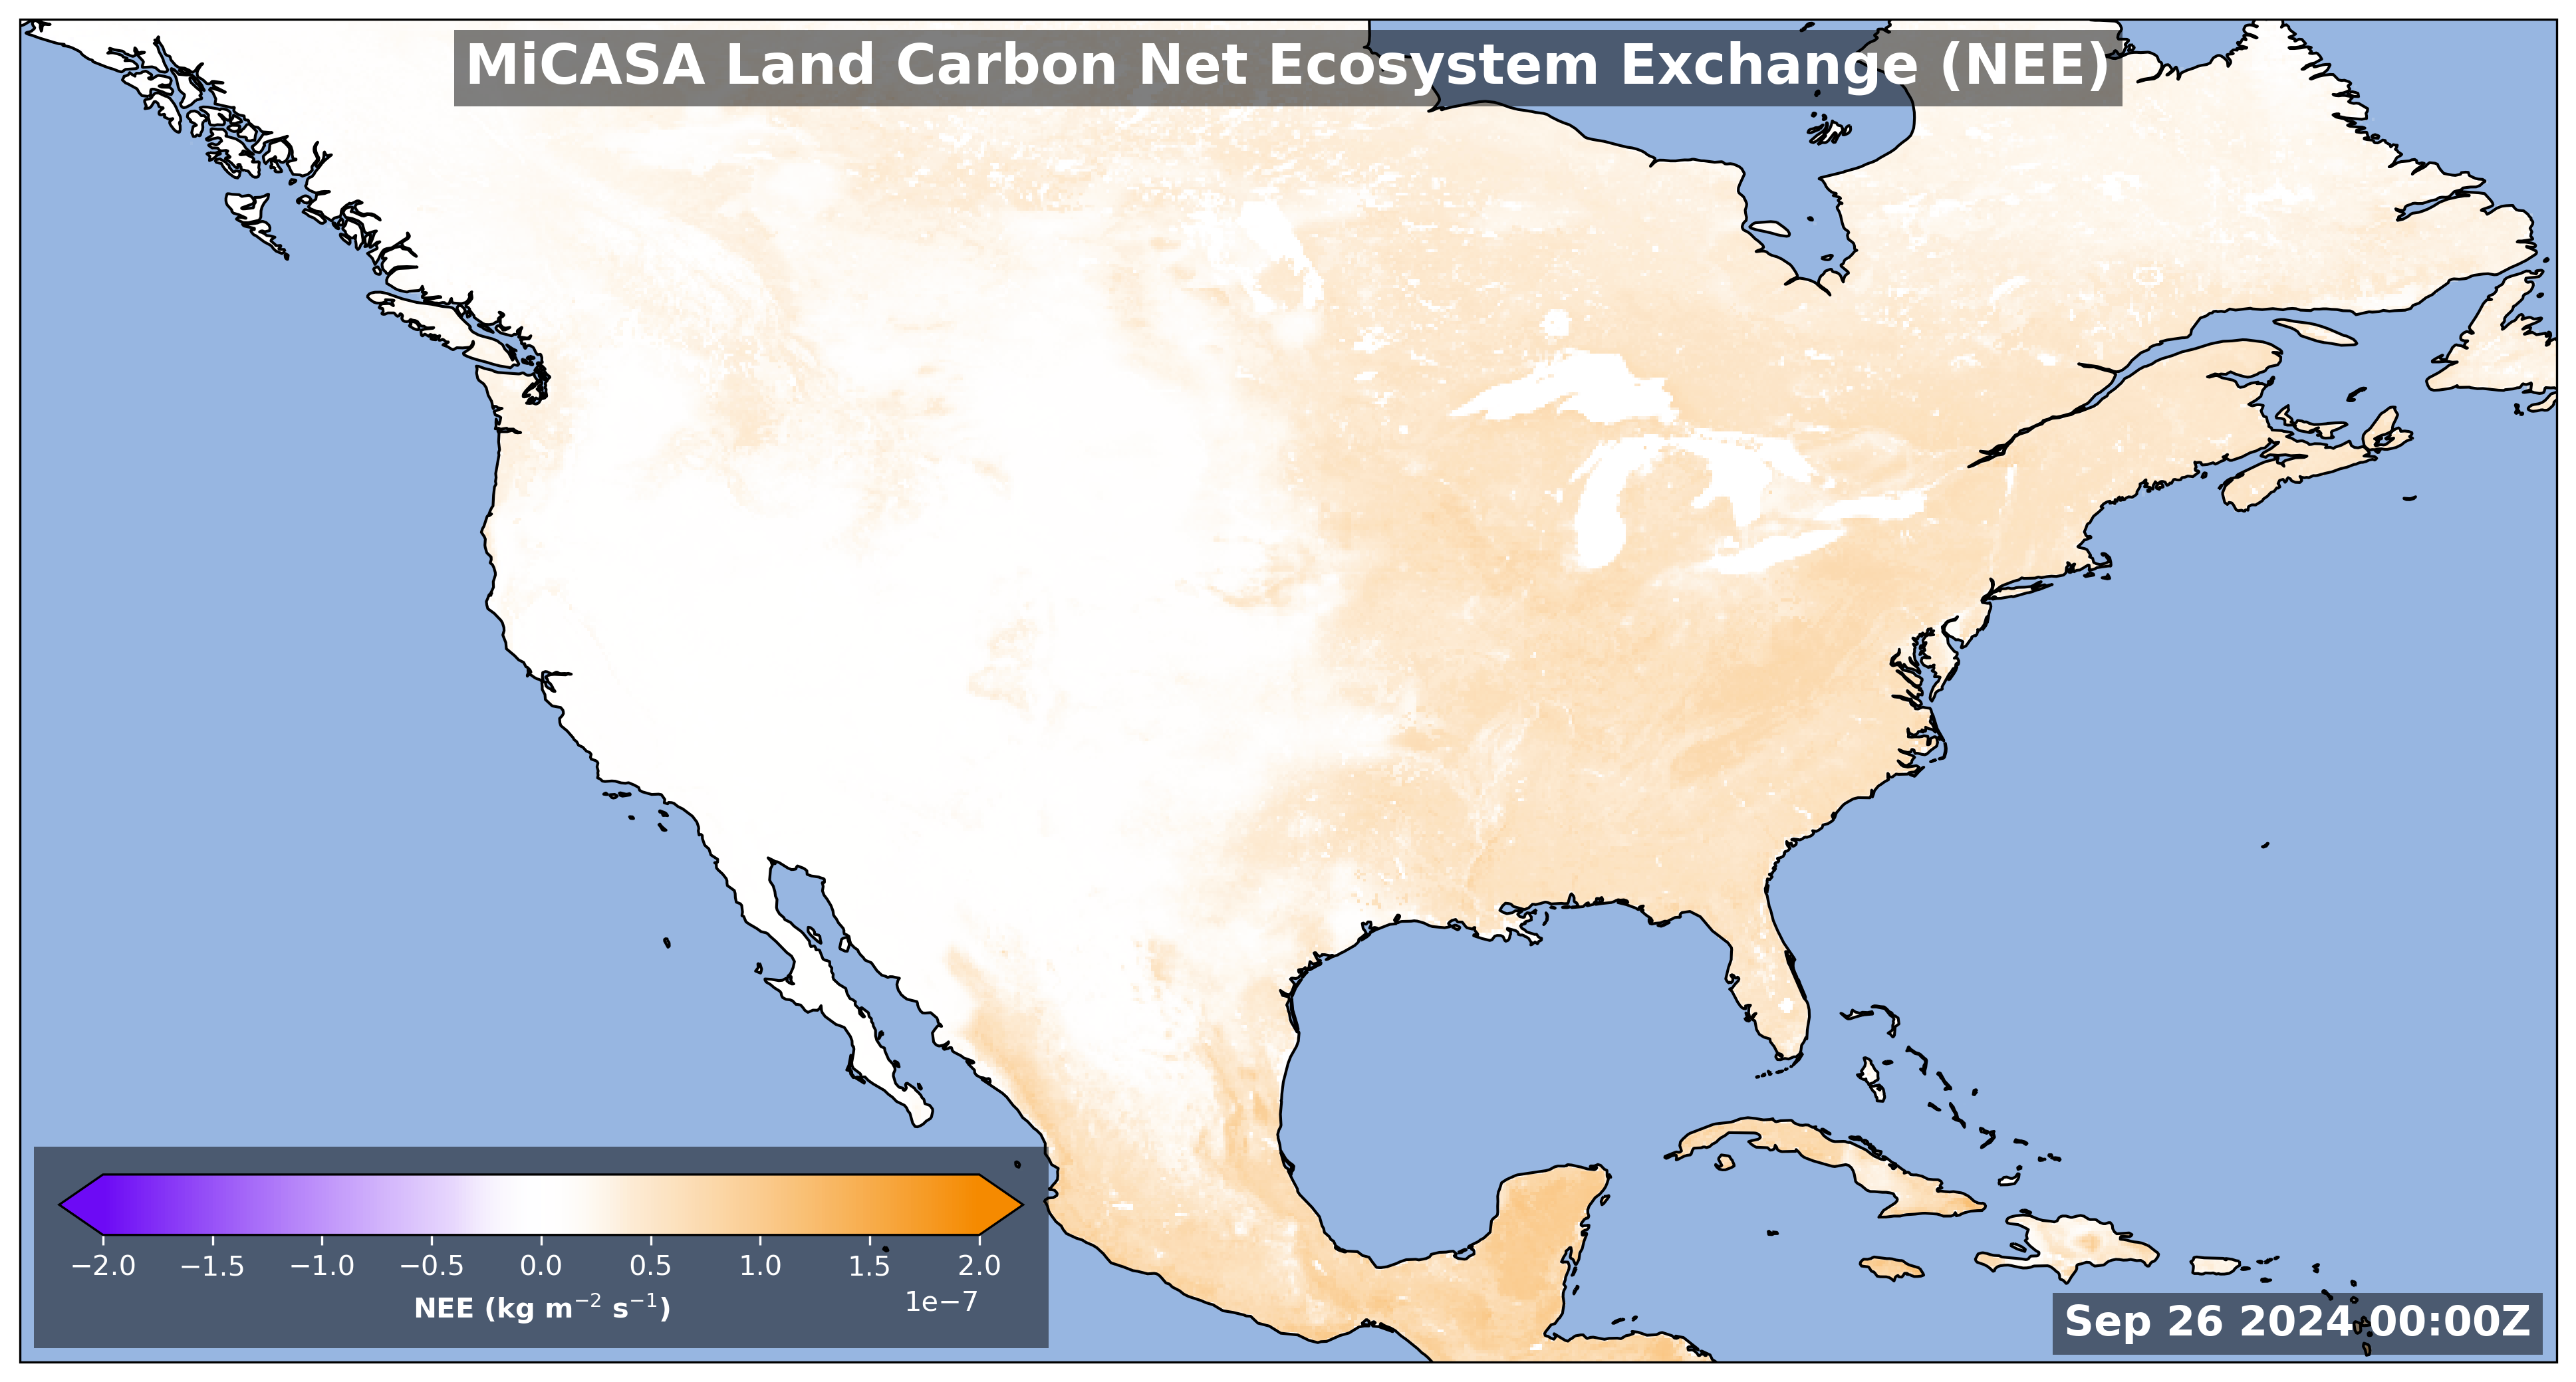

In [20]:
# Test plot no imagery (for speed)
fig, ax = plt.subplots(figsize=(12.8, 7.2),dpi=300,subplot_kw= {'projection': proj},layout='constrained')

title_str = 'MiCASA Land Carbon Net Ecosystem Exchange (NEE)'
ax.set_title(title_str, fontsize=20,  weight='bold', c='w',
             y=0.94,
            bbox=dict(facecolor=[0,0,0,0.5], edgecolor='None'))

ax.set_extent([min_lon,max_lon,min_lat,max_lat], crs=proj)
ax.coastlines()
ax.add_feature(cfeature.OCEAN)

# Subset data for the first time step
data_at_time = ds_subset_mask.isel(time=0)
im = ax.pcolormesh(data_at_time.lon, data_at_time.lat, data_at_time.variable,
                       cmap=custom_cmap,vmin=-2e-7, vmax=2e-7)

time_value = data_at_time.time.dt
time_str = time_value.strftime('%b %d %Y %H:%MZ').item()
# Add time bottom right
ax.text(0.99,0.02, time_str, fontsize=15, c='w', weight='bold', 
        ha='right',
        # va='bottom',
        transform=ax.transAxes,
       bbox=dict(facecolor=[0,0,0,0.5], edgecolor='None'))

# Create an inset axes for the colorbar and background
## Colorbar Background
cbbox = inset_axes(ax, 
                 width="40%", height="15%",
                 loc='lower left',
                )
cbbox.set_yticks([])
cbbox.set_xticks([])
cbbox.set_facecolor([0,0,0,0.5])
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]

## Colorbar
cax = inset_axes(cbbox, 
                 width="95%", height="30%",
                 loc='upper center',
                borderpad=1,
                )
# Create colorbar
cbar = plt.colorbar(im, 
                    cax=cax, 
                    orientation='horizontal',
                    extend='both',
                   )
cbar.set_label(label = "NEE (kg m$^{-2}$ s$^{-1}$)",weight='bold',c='w')
cbar.ax.tick_params(which='both',color='white',labelcolor='white')

# Put time label above colorbar
# cax.text(0.5,1.9, time_str, fontsize=15, c='w', weight='bold', ha='center',
#         transform=cax.transAxes,
#        bbox=dict(facecolor=[0,0,0,0.5], edgecolor='None'))

In [39]:
# Testing background maps
# Import basemap image saved locally
# map_path = 'image-downloads/MODIS_Terra_CorrectedReflectance_TrueColor.png'
map_path = 'image-downloads/BlueMarble_ShadedRelief_Bathymetry.png'

# cartopy_files = os.path.join(cartopy.config['data_dir'],'mapimgs/')
# map_path = os.path.join(cartopy_files, 'world.topo.bathy.200409.3x5400x2700.jpg')


# Read in image  using maplotlib
img = plt.imread(map_path)
# Define the image (covers the entire Earth)
img_extent = (-180, 180, -90, 90)

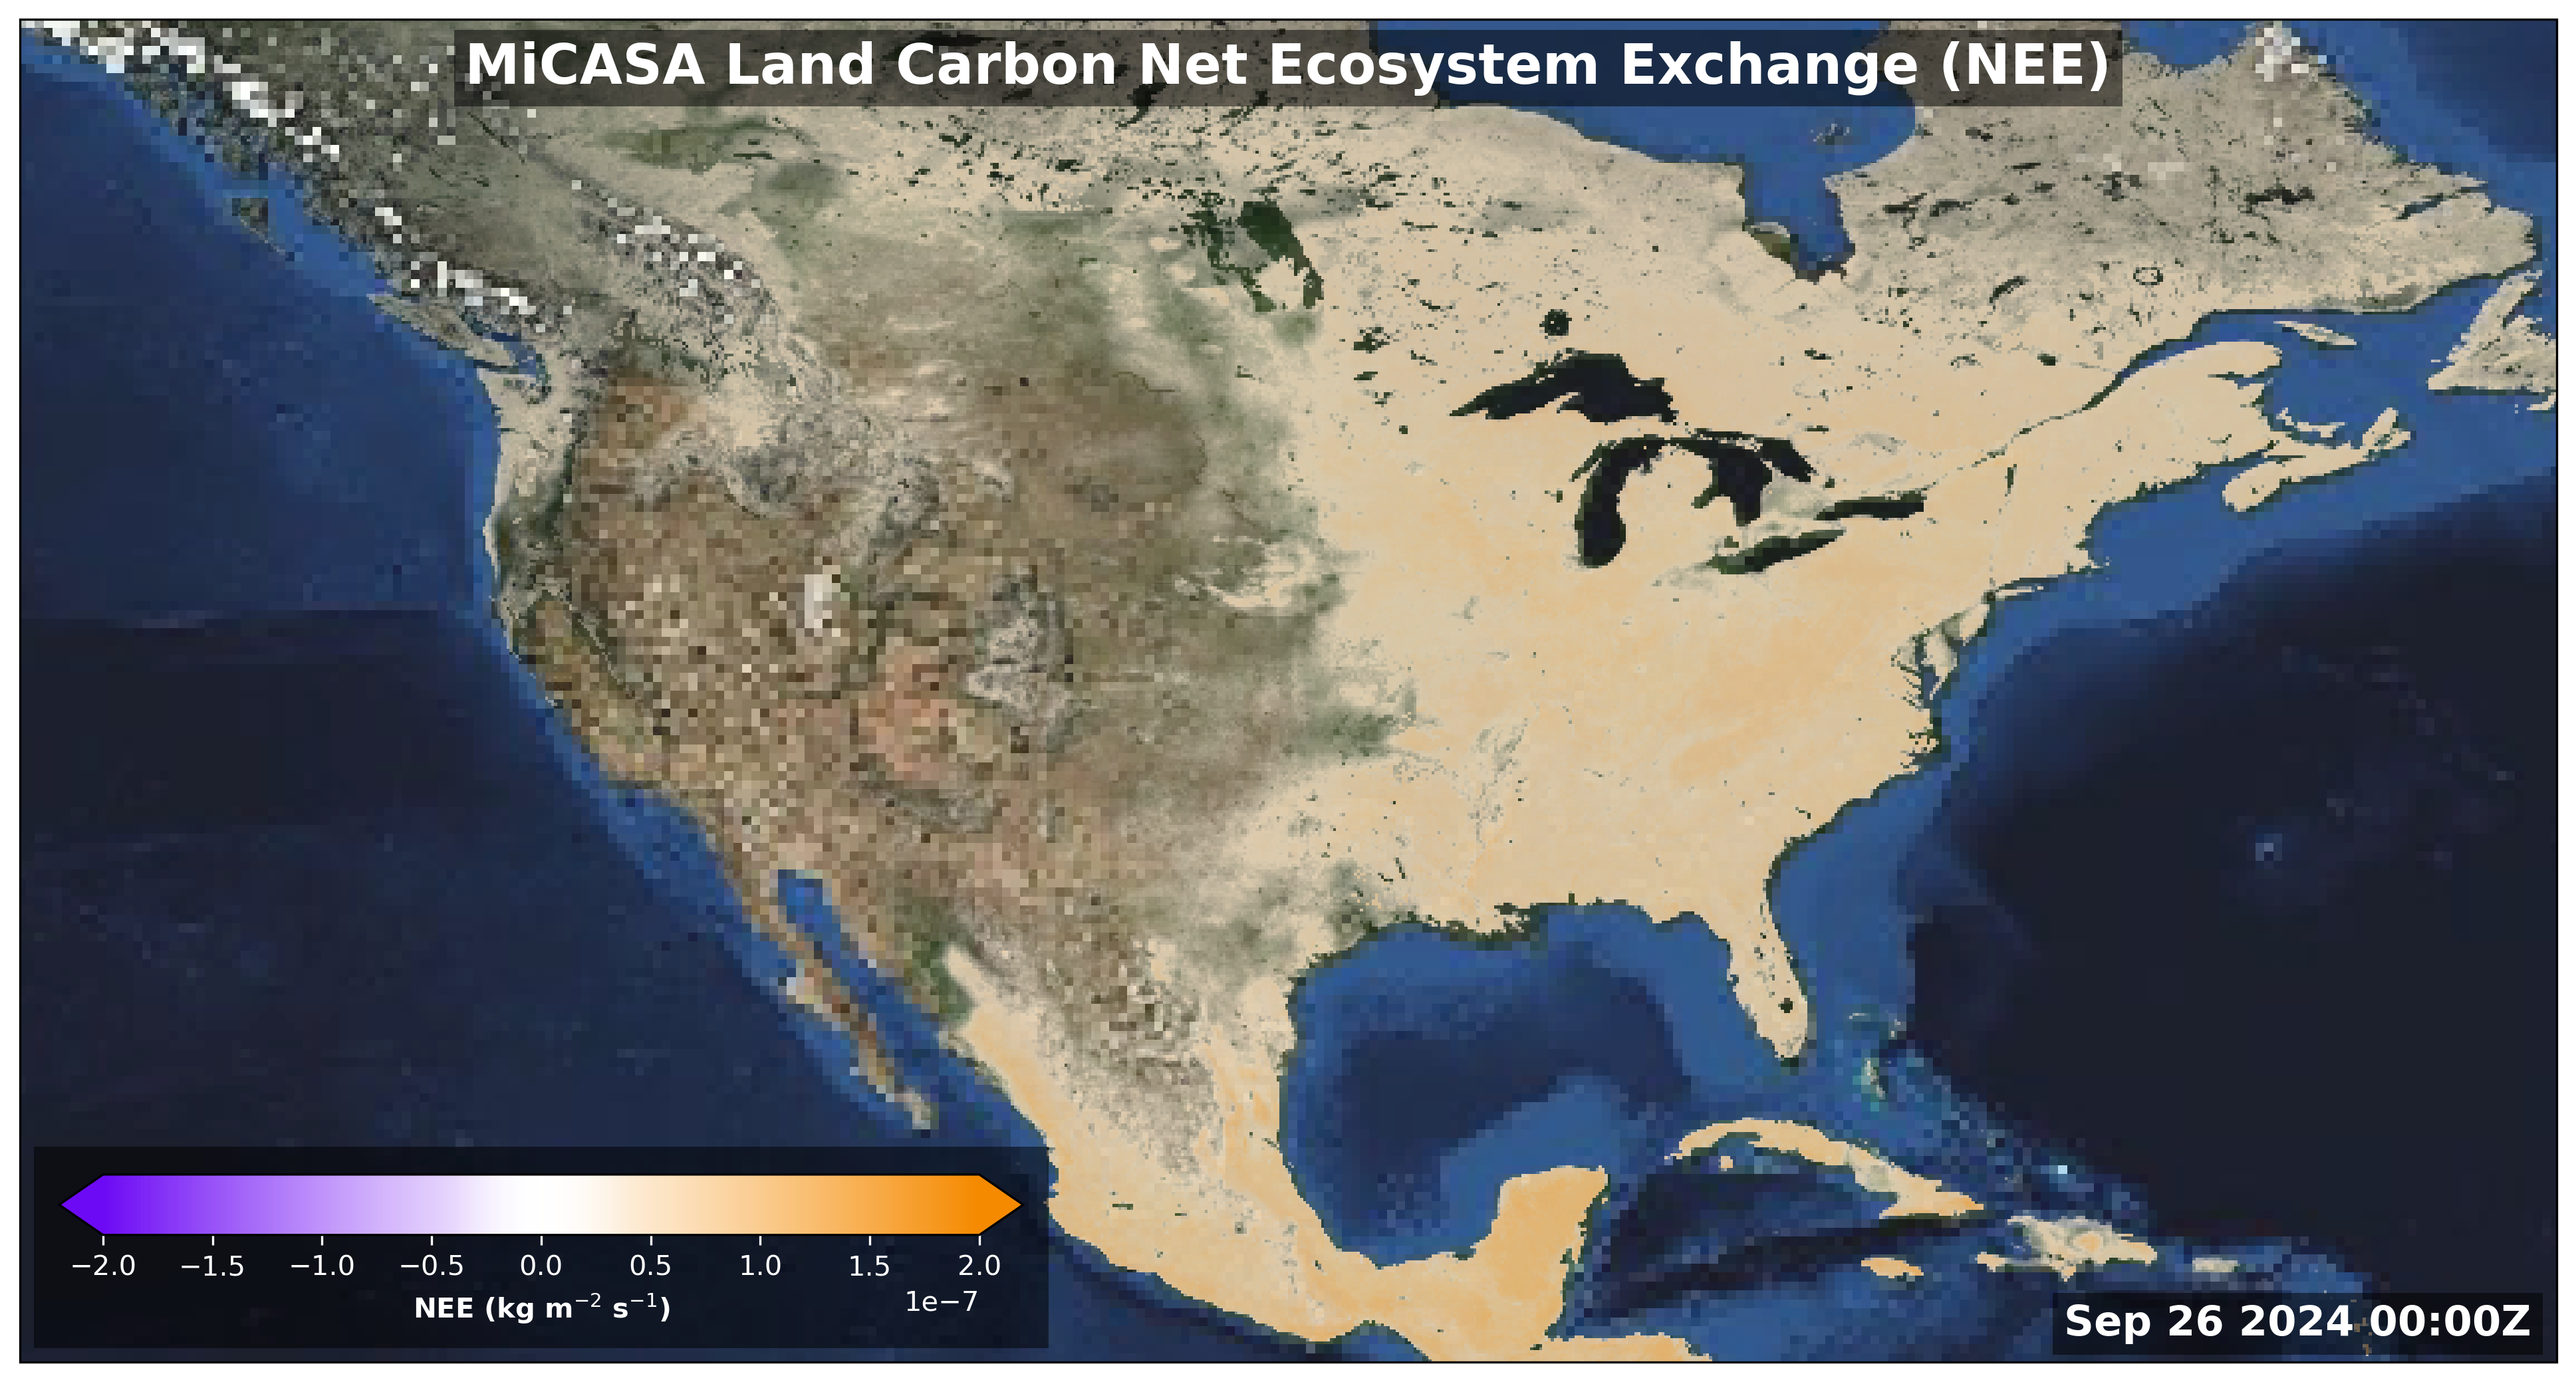

In [40]:
# Testing plot with bounding box
# Create figure and axes
fig, ax = plt.subplots(figsize=(12.8, 7.2),dpi=300,subplot_kw= {'projection': proj},layout='constrained')

title_str = 'MiCASA Land Carbon Net Ecosystem Exchange (NEE)'
ax.set_title(title_str, fontsize=20,  weight='bold', c='w',
             y=0.94,
            bbox=dict(facecolor=[0,0,0,0.5], edgecolor='None'))

ax.set_extent([min_lon,max_lon,min_lat,max_lat], crs=proj)

# Background image
ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree(),alpha=0.9)

# Subset and plot data
data_at_time = ds_subset_mask.isel(time=0)
im = ax.pcolormesh(data_at_time.lon, data_at_time.lat, data_at_time.variable,
                       cmap=custom_cmap,vmin=-2e-7, vmax=2e-7)

# Extract datetime string
time_value = data_at_time.time.dt
time_str = time_value.strftime('%b %d %Y %H:%MZ').item()
# Add time bottom right
ax.text(0.99,0.02, time_str, fontsize=15, c='w', weight='bold', 
        ha='right',
        # va='bottom',
        transform=ax.transAxes,
       bbox=dict(facecolor=[0,0,0,0.5], edgecolor='None'))

# Create an inset axes for the colorbar and background
## Colorbar Background
cbbox = inset_axes(ax, 
                 width="40%", height="15%",
                 loc='lower left',
                )
cbbox.set_yticks([])
cbbox.set_xticks([])
cbbox.set_facecolor([0,0,0,0.5])
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]

## Colorbar
cax = inset_axes(cbbox, 
                 width="95%", height="30%",
                 loc='upper center',
                borderpad=1,
                )
# Create colorbar
cbar = plt.colorbar(im, 
                    cax=cax, 
                    orientation='horizontal',
                    extend='both',
                   )
cbar.set_label(label = "NEE (kg m$^{-2}$ s$^{-1}$)",weight='bold',c='w')
cbar.ax.tick_params(which='both',color='white',labelcolor='white')

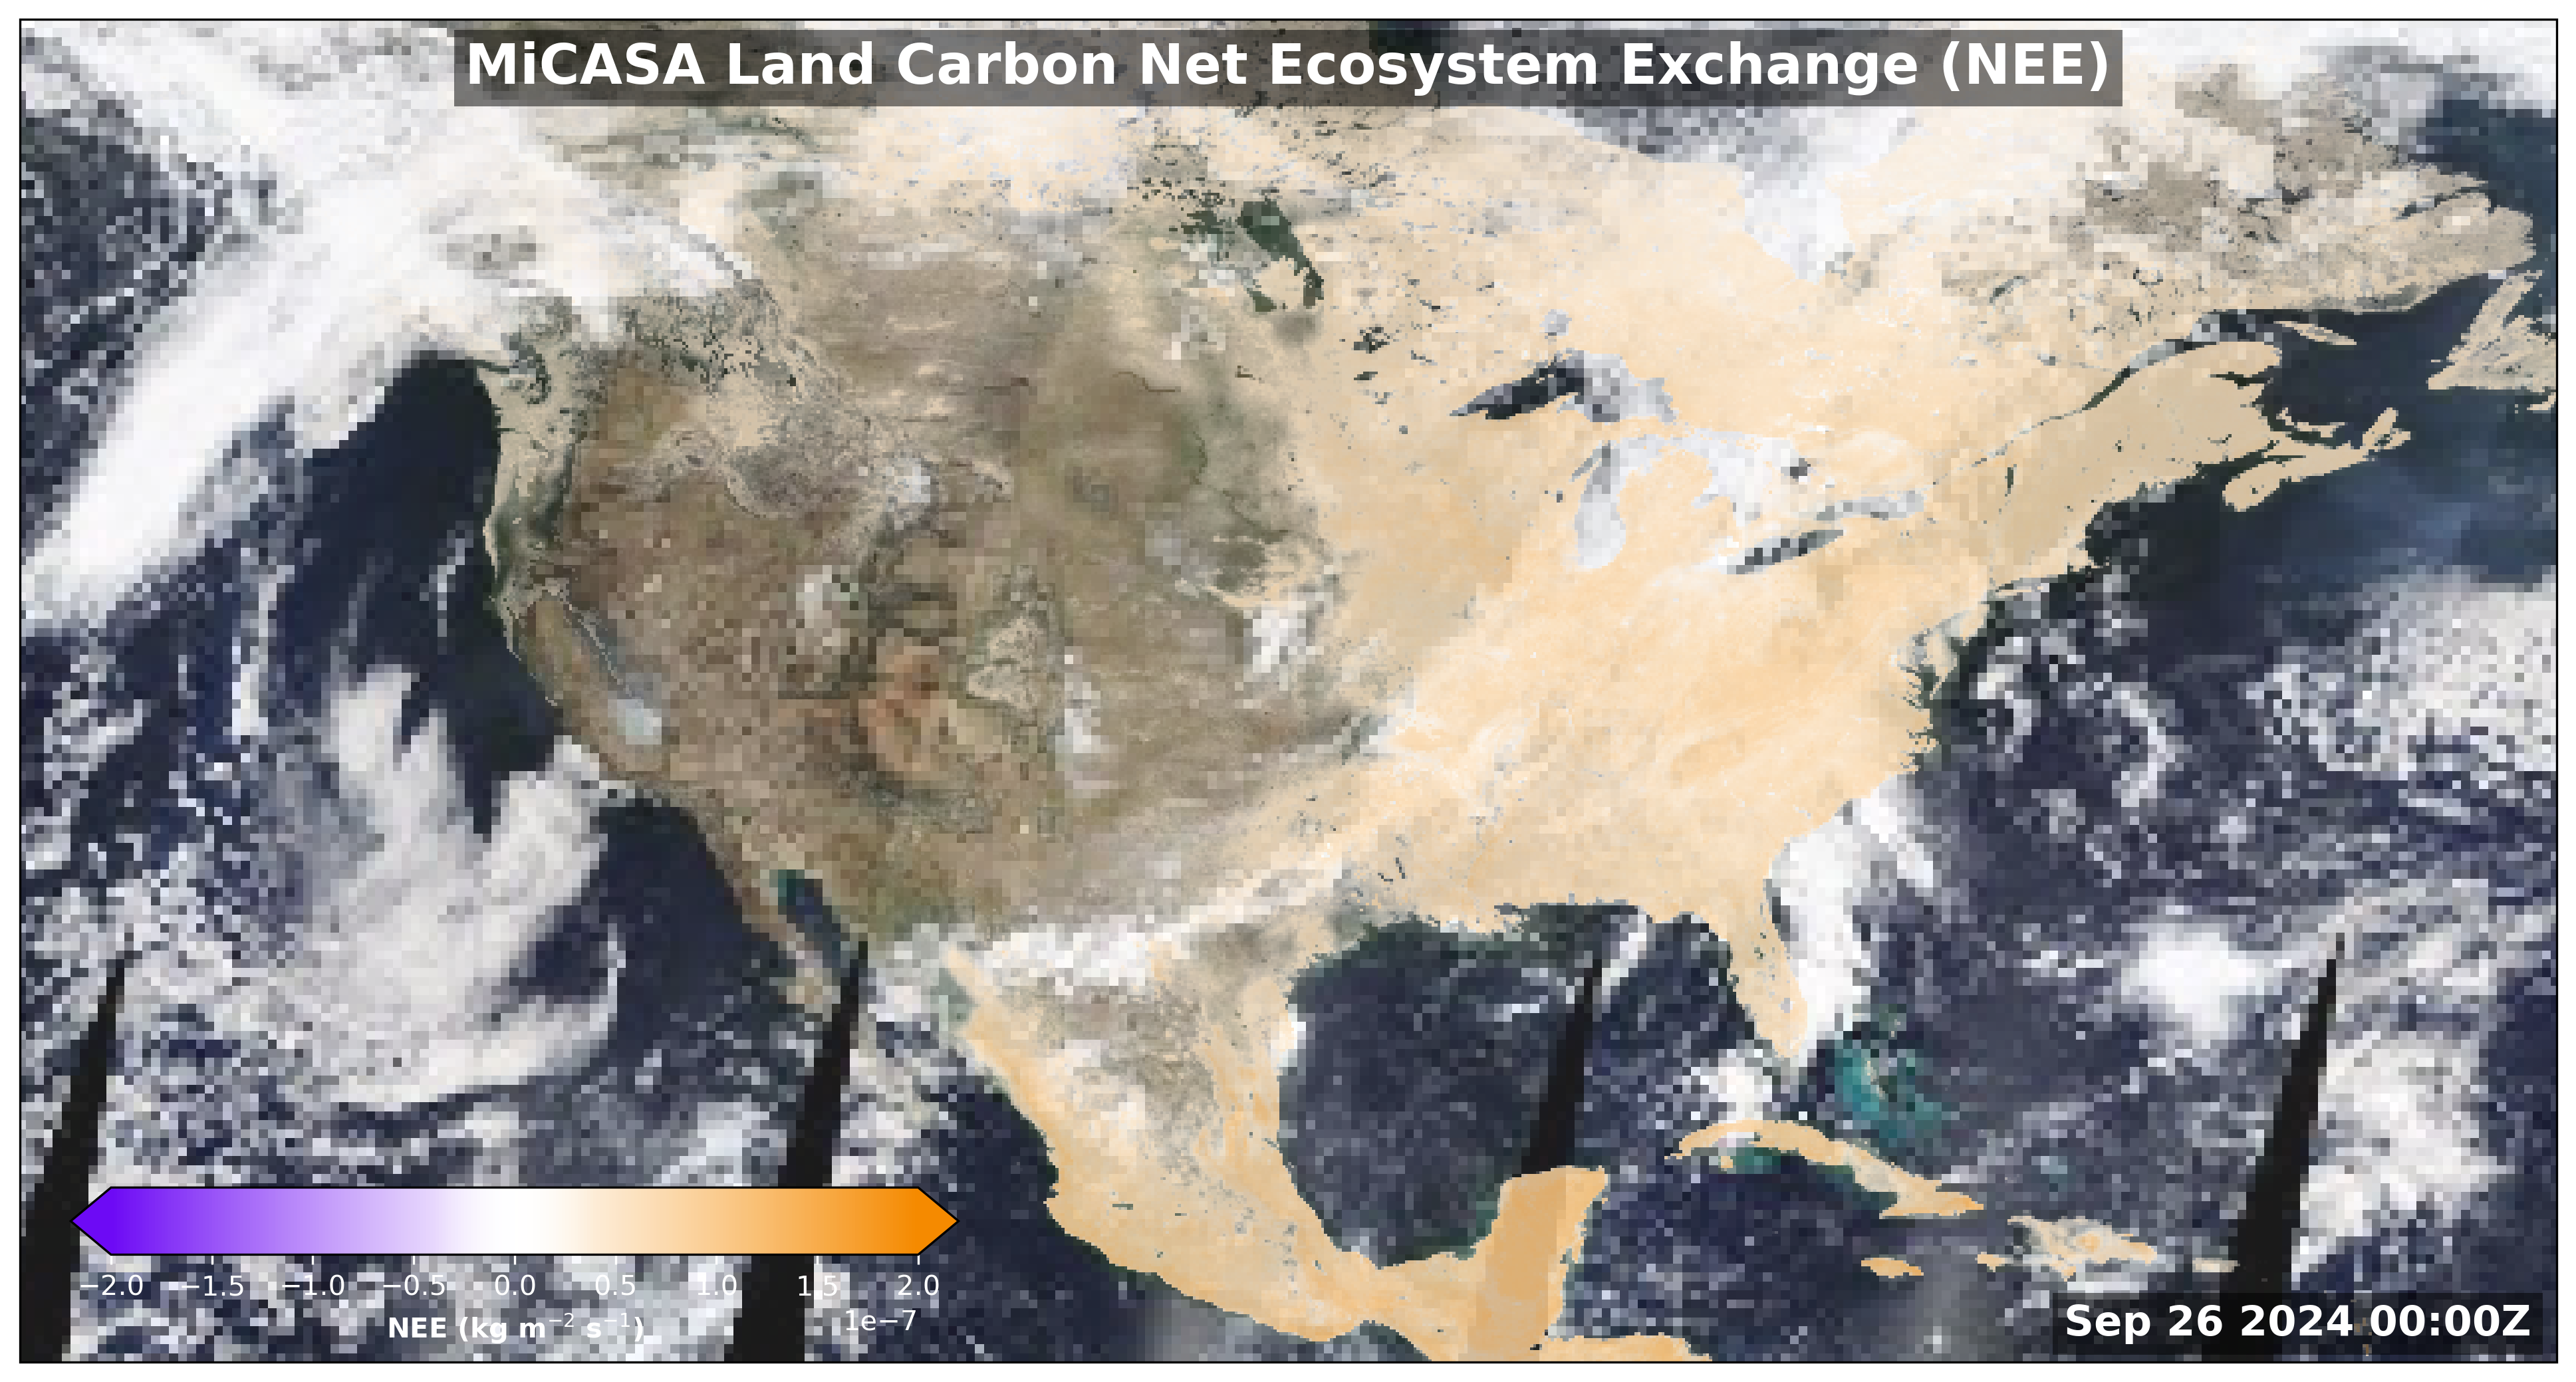

In [38]:
# Testing plot no bounding box
# Create figure and axes
fig, ax = plt.subplots(figsize=(12.8, 7.2),dpi=300,subplot_kw= {'projection': proj},layout='constrained')

title_str = 'MiCASA Land Carbon Net Ecosystem Exchange (NEE)'
ax.set_title(title_str, fontsize=20,  weight='bold', c='w',
             y=0.94,
            bbox=dict(facecolor=[0,0,0,0.5], edgecolor='None'))

ax.set_extent([min_lon,max_lon,min_lat,max_lat], crs=proj)

# Background image
ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree(),alpha=0.9)

# Subset and plot data
data_at_time = ds_subset_mask.isel(time=0)
im = ax.pcolormesh(data_at_time.lon, data_at_time.lat, data_at_time.variable,
                       cmap=custom_cmap,vmin=-2e-7, vmax=2e-7)

# Extract datetime string
time_value = data_at_time.time.dt
title_str = time_value.strftime('%b %d %Y %H:%MZ').item()
# Add time bottom right
ax.text(0.99,0.02, time_str, fontsize=15, c='w', weight='bold', 
        ha='right',
        # va='bottom',
        transform=ax.transAxes,
       bbox=dict(facecolor=[0,0,0,0.5], edgecolor='None'))

# Create an inset axes for the colorbar and background
## Colorbar
cax = inset_axes(ax, 
                 width="35%", height="5%",
                 loc='lower left',
                 bbox_to_anchor=(0.02, 0.08, 1, 1), 
                bbox_transform=ax.transAxes,
                 borderpad=0)

# Create colorbar
cbar = plt.colorbar(im, 
                    cax=cax, 
                    orientation='horizontal',
                    extend='both',
)
cbar.set_label(label = "NEE (kg m$^{-2}$ s$^{-1}$)",weight='bold',c='w')
cbar.ax.tick_params(which='both',color='white',labelcolor='white')

In [23]:
plt.savefig('test.png',dpi=300, bbox_inches='tight', pad_inches=0)

<Figure size 640x480 with 0 Axes>

# Old testing

In [24]:
# filedt = time_value.strftime('%Y%m%d%HZ').item()
# print(filedt,type(filedt))

# frame = f"{output_dir}/{filename}_{filedt}.png"
# print(frame)

In [25]:
# print(time_value.day)

# if time_value.day == 1:
#     print('Yes')

In [26]:
# for i, t in enumerate(ds_subset_mask.time):
#     iter_start = time.time()
    
#     fig, ax = plt.subplots(figsize=(8, 6),subplot_kw= {'projection': proj})
#     # ax.stock_img() # default basemap
#     ax.set_extent([min_lon,max_lon,min_lat,max_lat], crs=proj)
    
#     # Subset data for the current time step
#     data_at_time = ds_subset_mask.isel(time=i)
    
#     # Create plot
#     im = ax.pcolormesh(data_at_time.lon, data_at_time.lat, data_at_time.variable,
#                        cmap=custom_cmap, vmin=-2e-7, vmax=2e-7)

#     time_value = pd.to_datetime(data_at_time.time.values)
#     title = time_value.strftime('%b %d %Y')
#     ax.set_title(title)

#     # Add colorbar
#     cbar = plt.colorbar(im, ax=ax, orientation='horizontal',pad=0.05)
#     cbar.set_label("NEE (kg m$^{-2}$ s$^{-1}$)")
#     # Save frame
#     filedt = time_value.strftime('%Y%m%d')
#     frame = f"{output_dir}/{filename}_{filedt}.png"
#     plt.savefig(frame, dpi=150)
#     plt.close(fig)  # Free memory
# print("Frame generation complete.")

In [27]:
# iter_start = time.time()
# iter_end = time.time()
# iter_elapsed = iter_end - iter_start
# iter_minutes = int(iter_elapsed // 60)
# iter_seconds = int(iter_elapsed % 60)
# print(f"Iteration took {iter_minutes} min {iter_seconds} sec")

In [28]:
# from PIL import Image
# import urllib.request
# image_url   = ' https://svs.gsfc.nasa.gov/cgi-bin/wms?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&LAYERS=2915_21224&FORMAT=image/png&WIDTH=2048&HEIGHT=1024&CRS=CRS:84&BBOX=-180.0,-90.0,180.0,90.0&STYLES='
# with urllib.request.urlopen(image_url) as url:
#     img = Image.open(url)
#     img = np.array(img)  # Convert image to NumPy array
# mpl.image.imread('')

In [29]:
# import basemap from Joe's directory:
# map_path = '/discover/nobackup/jardizzo/maps/BlackMarble_2016/BlackMarble_2016_2048x1024.png'

In [30]:
# plt.title(time_str, y=1.0, pad=-40, weight='bold',c='w',
#                      bbox=dict(facecolor=[0,0,0,0.5], edgecolor='None')
#             )